Implementation for an [example](https://docs.pymc.io/en/stable/pymc-examples/examples/getting_started.html) form the PyMC documentation, plus doing predictions.

In [18]:
import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az
import scipy.stats as stats
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [19]:
print(f"Running on PyMC3 v{pm.__version__}")
print(f"Running on ArviZ v{az.__version__}")

Running on PyMC3 v3.11.4
Running on ArviZ v0.11.4


In [20]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 56183
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

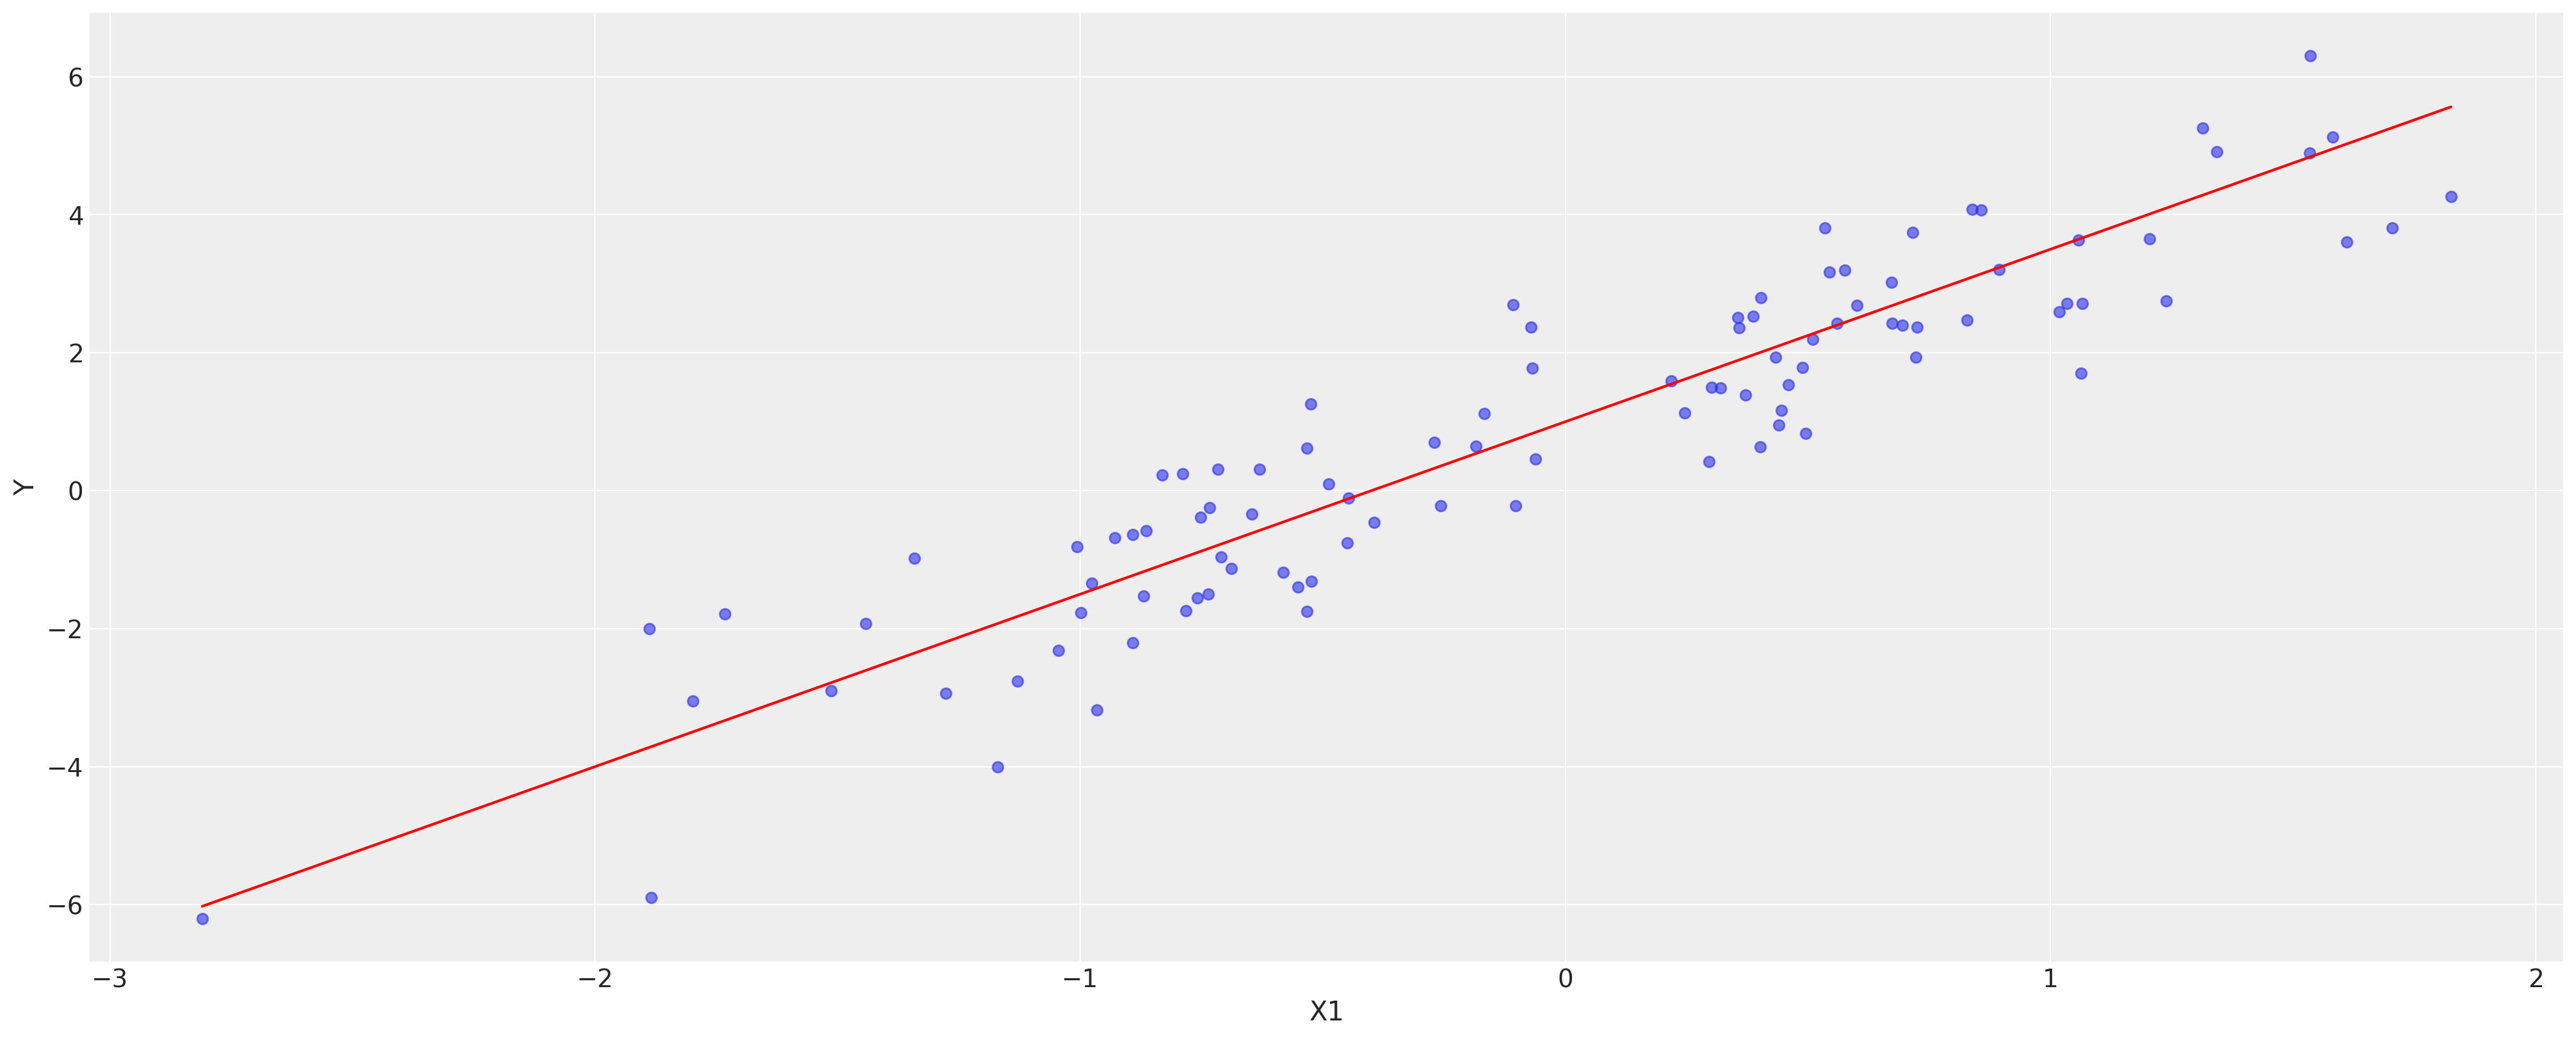

In [21]:
real_alpha, real_sigma = 1, 1
real_beta = 2.5
size = 100

X1 = np.random.randn(size)
Y = real_alpha + real_beta * X1 + np.random.randn(size) * real_sigma

line_1_x = np.linspace(X1.min(), X1.max(), 10)
line_1_y = real_alpha + real_beta * line_1_x


fig, ax1 = plt.subplots(figsize=(20, 8))
ax1.scatter(X1, Y, alpha=0.6)
ax1.plot(line_1_x, line_1_y, '-r')
ax1.set_ylabel("Y")
ax1.set_xlabel("X1");

In [22]:
basic_model = pm.Model()

with basic_model:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=1)

    mu = alpha + beta * X1 
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y) 
    
    trace = pm.sample(500, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 18 seconds.


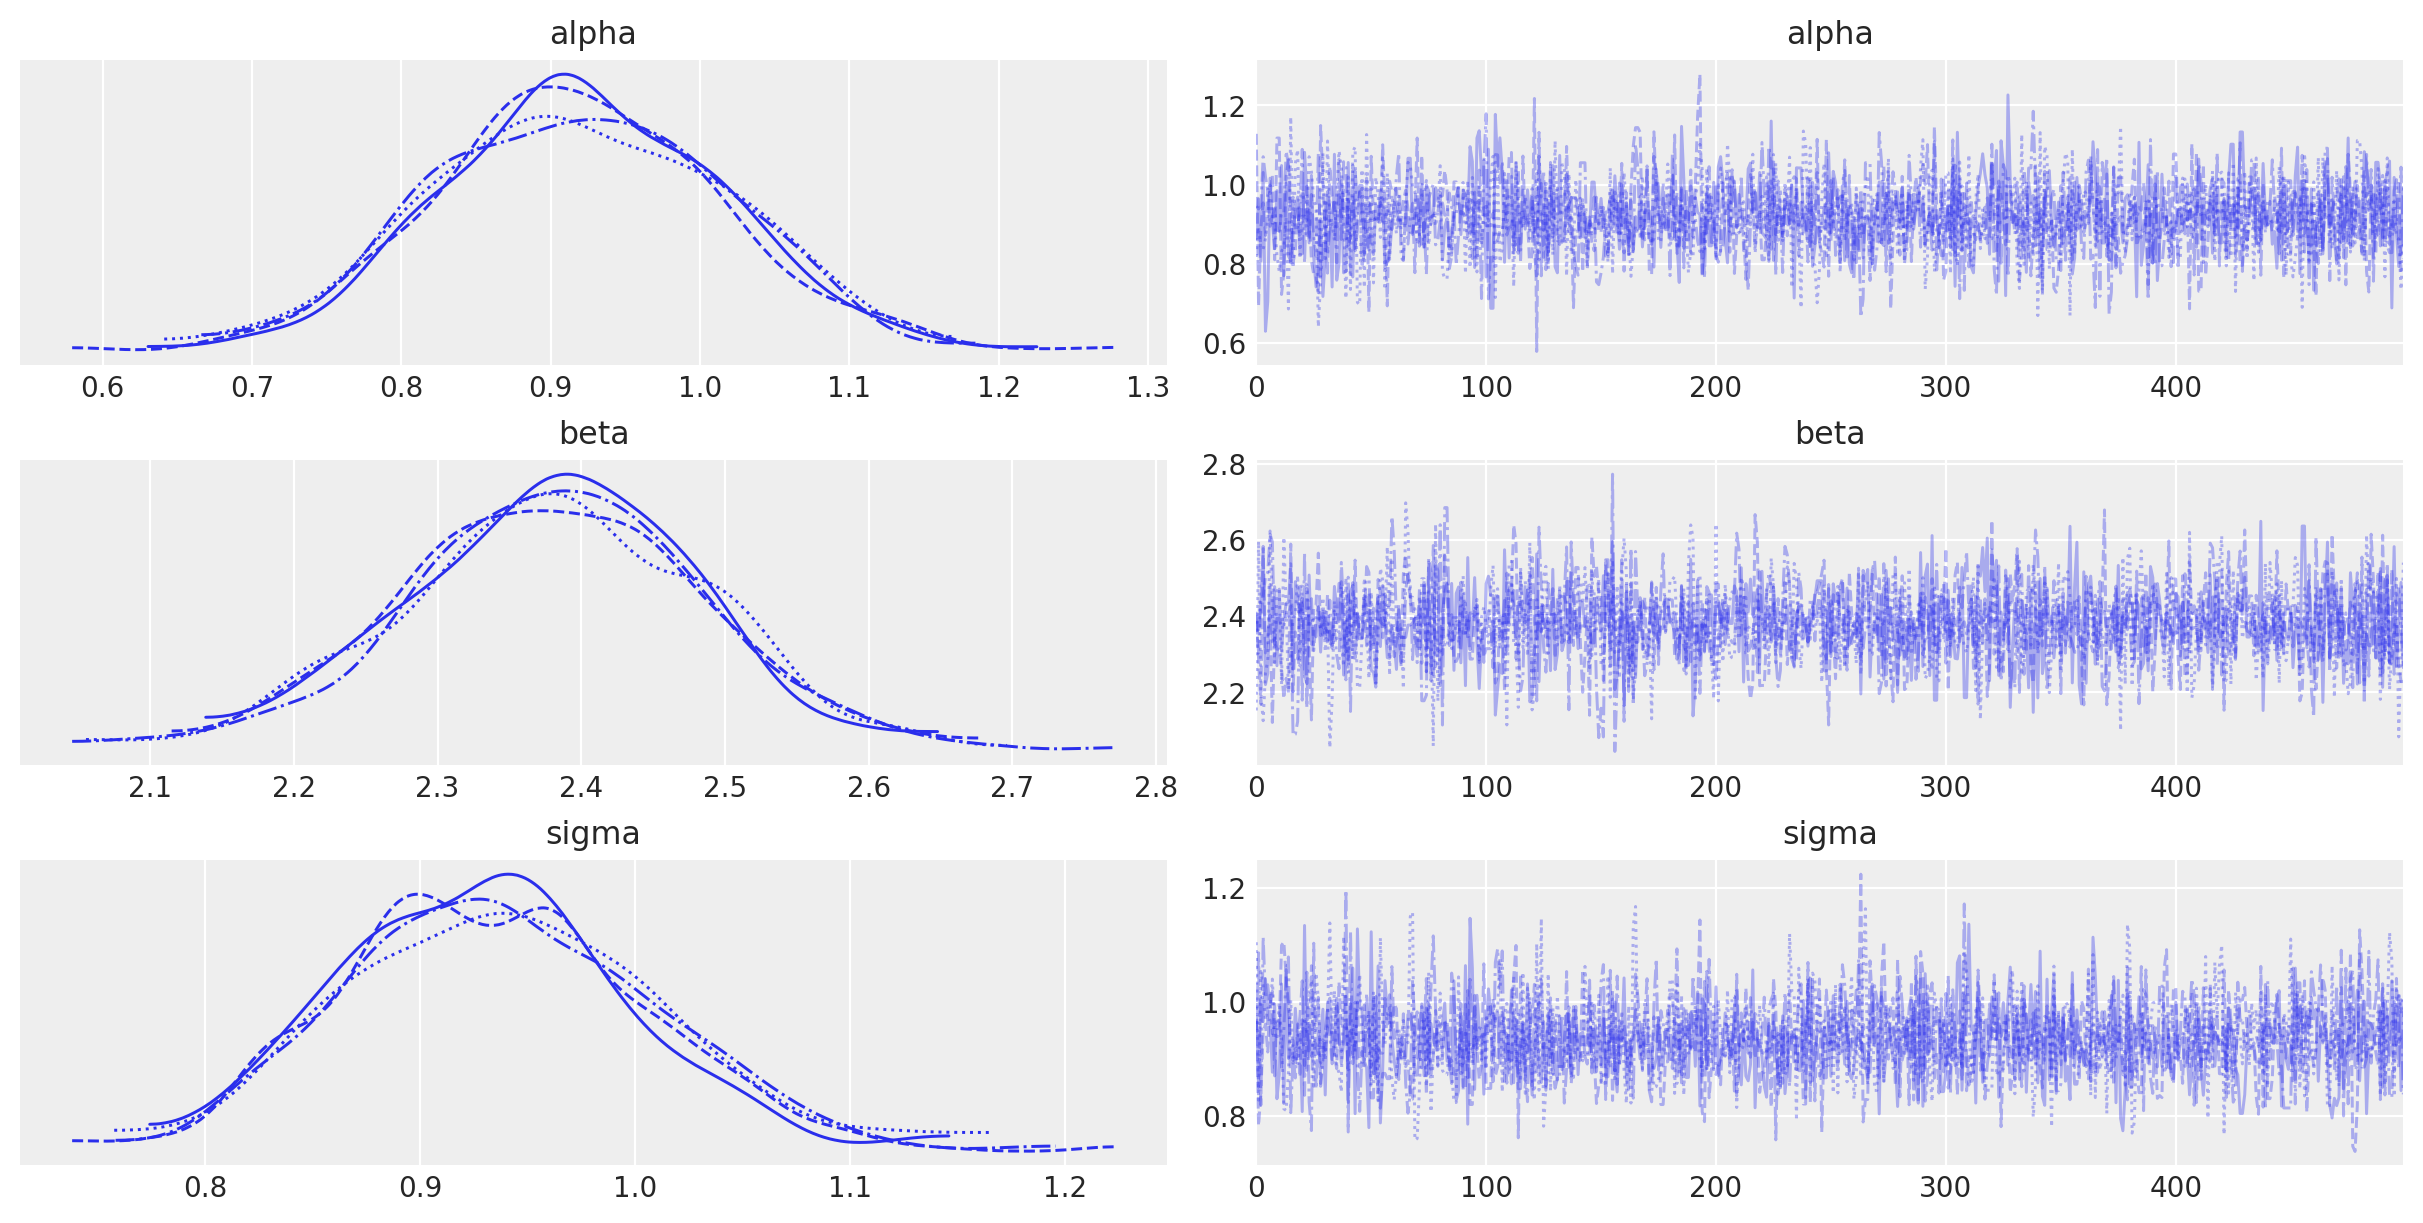

In [23]:
with basic_model:
    az.plot_trace(trace);

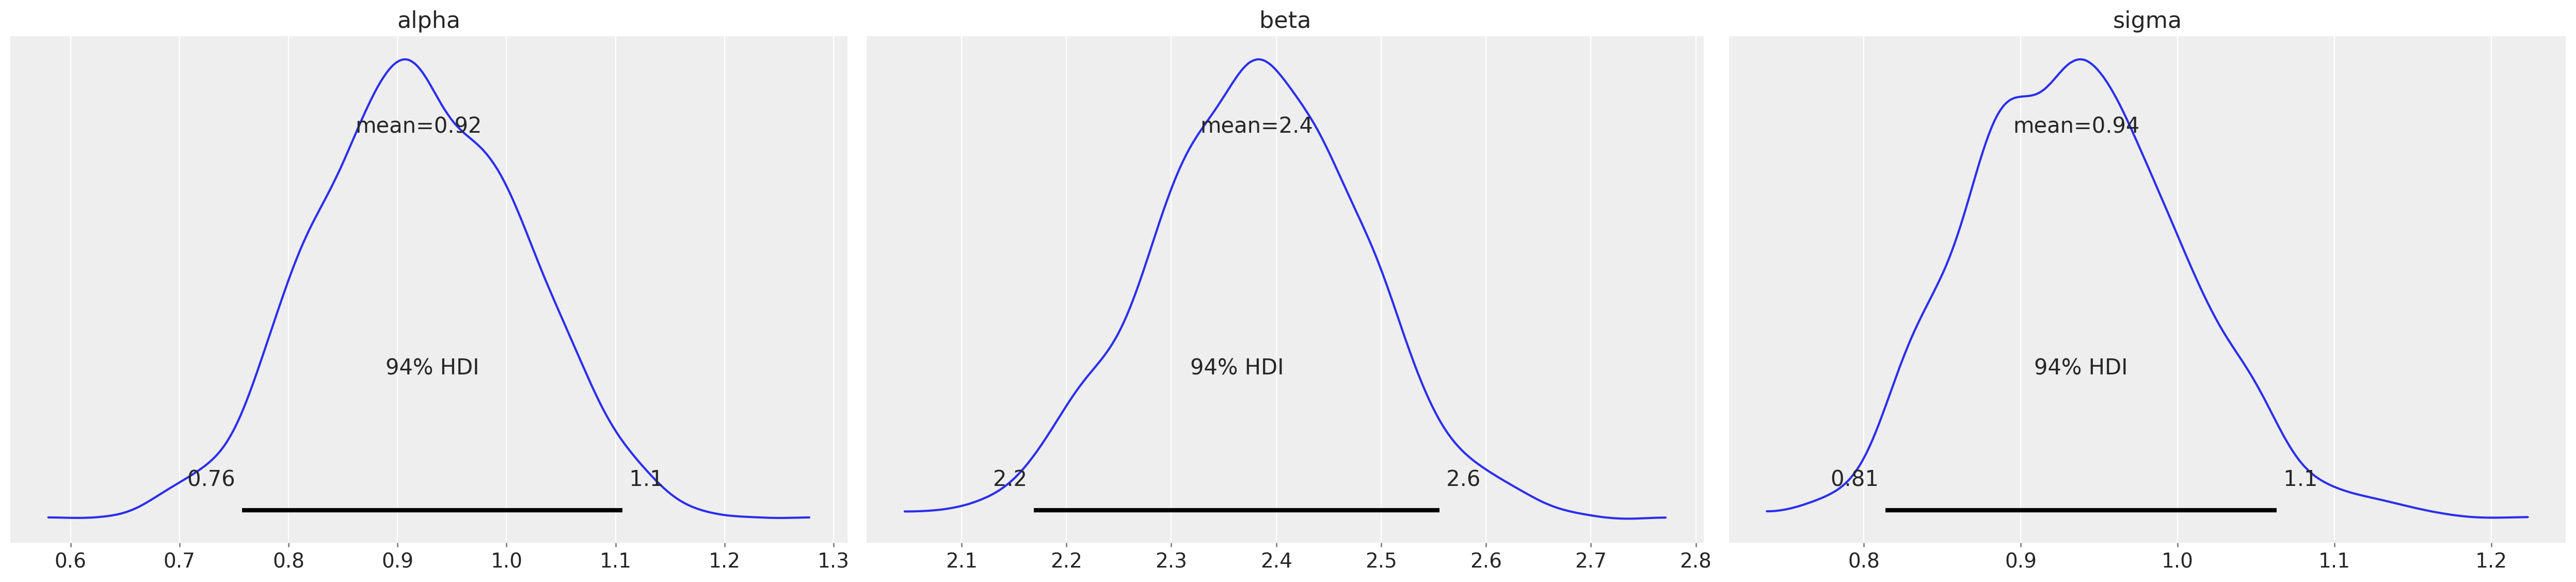

In [24]:
with basic_model:
    az.plot_posterior(trace);

In [25]:
# stats.norm.rvs(loc=10, scale=2, size=10)
with basic_model:
    trace_df = pm.trace_to_dataframe(trace)
    print(trace_df["sigma"].mean())
    display(az.summary(trace))

0.9356106165900314


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.919,0.095,0.757,1.107,0.002,0.001,2951.0,1433.0,1.0
beta,2.381,0.103,2.169,2.556,0.002,0.001,2622.0,1369.0,1.0
sigma,0.936,0.070,0.814,1.063,0.001,0.001,2464.0,1387.0,1.0


In [26]:
line_2_x = np.linspace(X1.min()-1, X1.max()+1, 10)
Y_pred = list()
for x in line_2_x:
    Y_pred.append(
        stats.norm.rvs(
            loc=trace["alpha"] + trace["beta"] * x,
            scale=trace["sigma"]
        )
    )
    
df_pred = pd.DataFrame(Y_pred, index=line_2_x)
df_pred

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
-3.809481,-7.917520,-7.747924,-8.815856,-7.594478,-8.052613,-6.613223,-6.981771,-8.066752,-9.355849,-7.668175,...,-5.898522,-7.789106,-9.331346,-8.709657,-9.443835,-8.290104,-7.116795,-8.436920,-7.099291,-8.113309
-3.072298,-5.777655,-5.721631,-6.530765,-7.385557,-5.822510,-5.947232,-7.839649,-5.856235,-7.891855,-6.331653,...,-6.558930,-7.852246,-6.647126,-6.353497,-5.066196,-5.582586,-6.562745,-7.292879,-7.012592,-5.101653
-2.335114,-6.131060,-4.084266,-5.048191,-5.162147,-3.639342,-4.483658,-7.434197,-2.862083,-5.533859,-4.087165,...,-3.102905,-5.181215,-4.782576,-3.281498,-4.506334,-3.632956,-5.490796,-5.248687,-4.292215,-5.693898
-1.597930,-2.766054,-3.193691,-2.400427,-2.878949,-3.654694,-2.982005,-2.121364,-2.771314,-3.108893,-2.865204,...,-2.930855,-1.985534,-3.411667,-2.391756,-2.346603,-2.957508,-2.372781,-4.782986,-1.921799,-2.850908
-0.860747,-0.575168,-1.304390,0.527629,-0.720556,-2.310059,-0.836322,-2.856593,-0.345744,-2.294709,-0.405349,...,-0.764593,-1.318836,-1.971091,-1.645014,-1.436827,-0.767142,-0.419934,-0.961290,-0.064440,-1.476432
-0.123563,-0.096997,0.288922,-0.514194,1.882436,0.569306,0.582681,1.060347,0.703571,1.650304,-0.459660,...,1.744061,1.507906,0.549244,1.771441,0.475194,0.682702,1.418888,2.331046,0.616686,1.183714
0.613621,1.891620,2.428995,2.164077,4.964356,0.998678,2.046459,1.846824,1.720079,1.770096,2.112180,...,2.386419,0.509029,3.078478,3.335050,1.858912,2.809032,2.630117,3.096756,2.482799,1.728093
1.350804,3.849858,3.969381,4.392741,3.970353,2.443468,3.723036,3.137616,4.085731,5.108077,4.547472,...,5.640927,5.968599,5.083555,4.637499,4.803990,3.580434,4.431334,5.176698,4.731233,3.474245
2.087988,4.198593,6.543131,5.719635,5.805054,5.260714,7.499917,7.764445,6.765225,7.410525,6.972841,...,2.696200,5.974663,6.698041,6.706628,4.778487,7.559862,5.413060,5.183761,7.414861,6.827310
2.825171,9.631048,8.409551,7.763713,7.778592,6.377921,7.164236,8.546375,7.465907,8.736566,7.147135,...,7.021405,6.731652,8.777645,9.624095,7.430027,9.680024,8.895937,7.677416,6.669837,8.818939


Text(0.5, 0, 'X1')

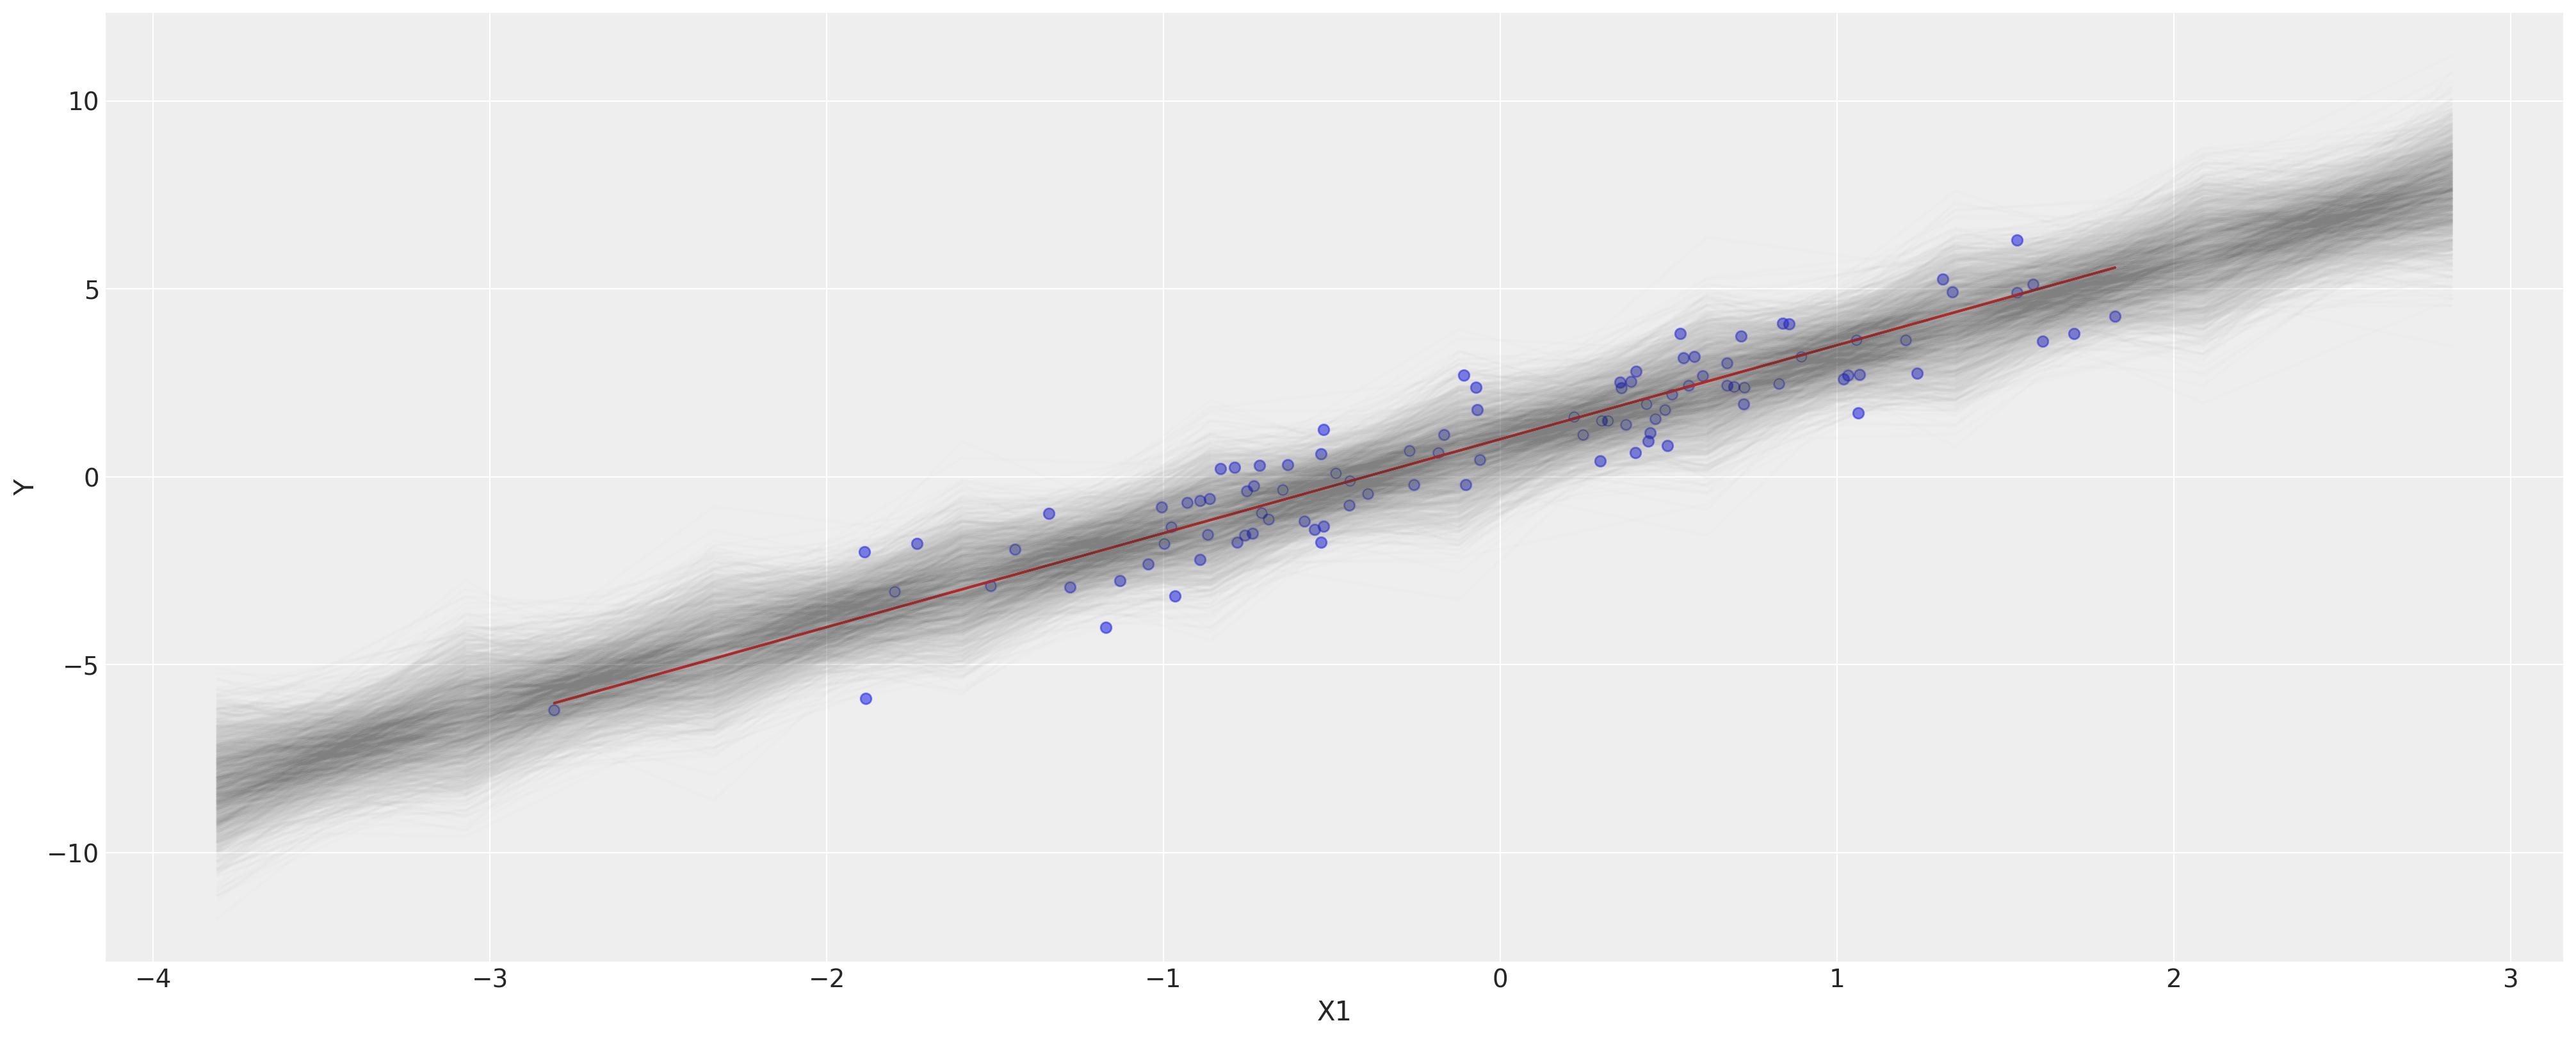

In [27]:
fig, ax1 = plt.subplots(figsize=(20, 8))
ax1.scatter(X1, Y, alpha=0.6)
ax1.plot(line_1_x, line_1_y, "-r")
ax1.plot(line_2_x, Y_pred, color="gray", alpha=0.01)
ax1.set_ylabel("Y")
ax1.set_xlabel("X1")

In [28]:
y_posteriors = pm.sample_posterior_predictive(trace, 200, basic_model)
y_posteriors

{'Y_obs': array([[-0.77025717,  2.31786413, -0.02369414, ...,  5.94200058,
          1.27047349,  3.13070912],
        [-0.21877443,  2.92548841,  0.51185692, ...,  7.36555735,
          2.59122426,  4.819955  ],
        [ 0.22569047,  2.69295049,  0.43825928, ...,  4.34581688,
          3.19277426,  1.56431067],
        ...,
        [-0.31297312,  3.16509425, -3.31104048, ...,  4.72568192,
          1.5787484 ,  2.89775194],
        [-0.15761795,  2.95009006,  1.64594128, ...,  6.49410281,
          2.99982824,  3.14834397],
        [-1.1565857 ,  1.42212439,  0.93996393, ...,  5.1365294 ,
          3.70464472,  5.38568454]])}

In [29]:
line_2_y = list()
for x in line_2_x:
    draw = stats.norm.rvs(
        loc=trace["alpha"] + trace["beta"] * x,
        scale=trace["sigma"]
    )
    line_2_y.append(draw.mean())

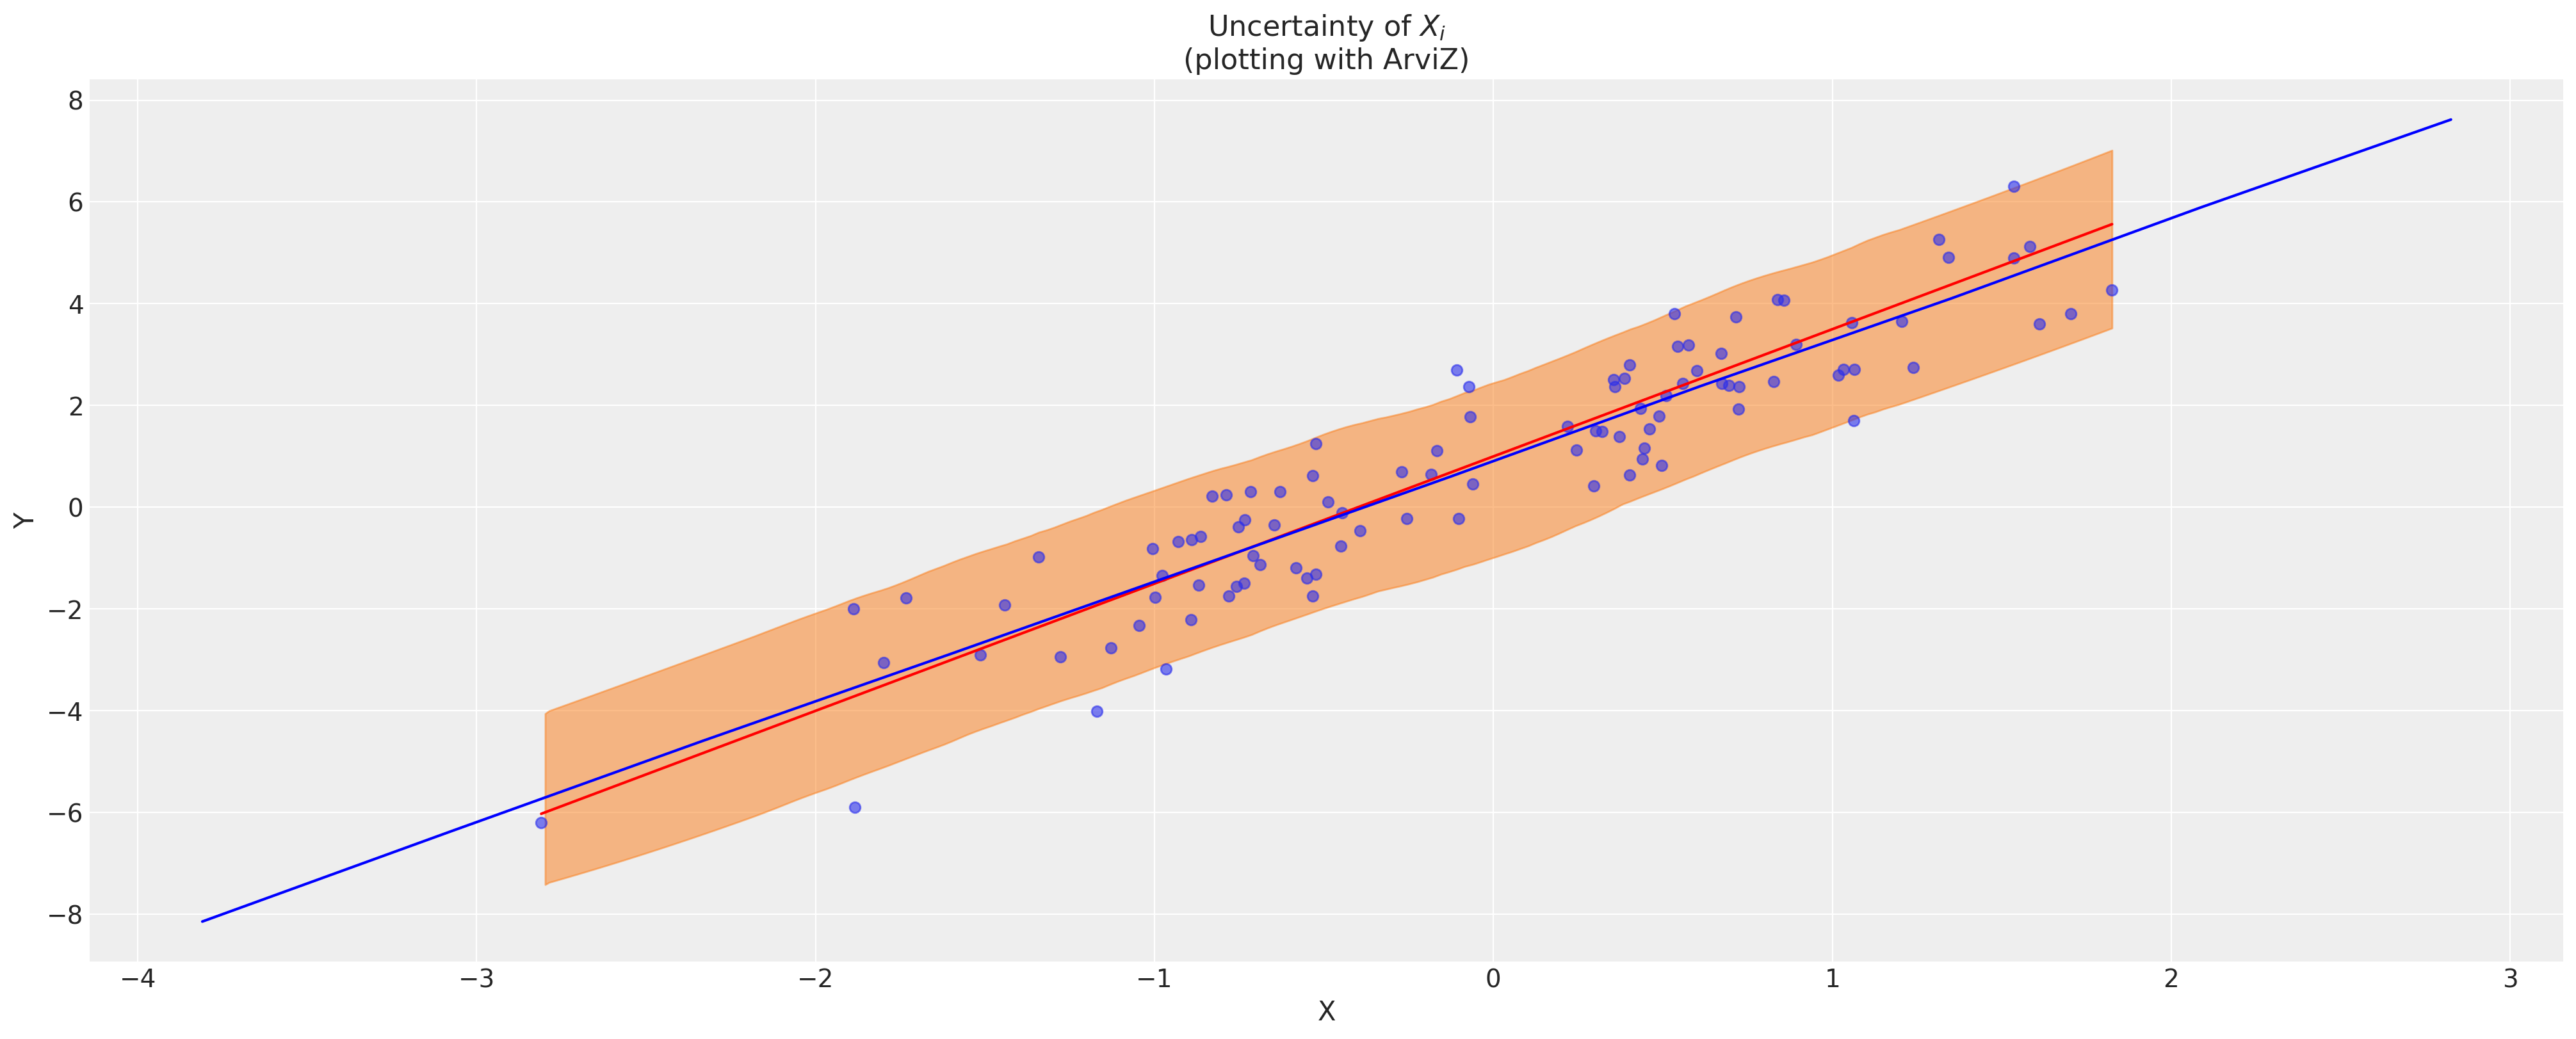

In [32]:
f, ax1 = plt.subplots(figsize=(20, 8))
az.plot_hdi(X1, y_posteriors["Y_obs"], ax=ax1)
ax1.plot(line_1_x, line_1_y, '-r')
ax1.plot(line_2_x, line_2_y, '-b')
ax1.scatter(X1, Y, alpha=0.6)
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_title("Uncertainty of $X_i$\n(plotting with ArviZ)");